# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom

import os

from sklearn.utils import class_weight


# Load the dataframe

In [2]:
train_df = pd.read_csv("../input/rsna-breast-cancer-detection/train.csv")
test_df = pd.read_csv("../input/rsna-breast-cancer-detection/test.csv")

In [3]:
# total number of rows is equal to number of unique image ids
len(train_df),train_df["image_id"].nunique()

(54706, 54706)

In [4]:
# total number of patients in train df
len(train_df.groupby("patient_id"))

11913

In [5]:
train_df.columns, test_df.columns

(Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
        'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
        'machine_id', 'difficult_negative_case'],
       dtype='object'),
 Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
        'implant', 'machine_id', 'prediction_id'],
       dtype='object'))

In [6]:
# lets see the columns that are not present in test df
set(train_df.columns) - set(test_df.columns)

{'BIRADS',
 'biopsy',
 'cancer',
 'density',
 'difficult_negative_case',
 'invasive'}

Our model must not rely on above features because they wont be present during inference.

In [7]:
# lets check if every patient has same values for cancer property
train_df.groupby("patient_id")["cancer"].nunique().value_counts()
# 1 means all the patients that has same value for all images
# 2 means that those patients has non cancer and cancer images at the same time

1    11433
2      480
Name: cancer, dtype: int64

In [8]:
# lets see couple of patients with cancer and non cancer images
grouped = train_df.groupby("patient_id")
# filter patients that has both cancer or both non cancer images

count = 0
for patient_id, group in grouped:
    if group["cancer"].nunique() == 1:
        continue

    display(group)
        
    count += 1 # stop after 10 examples
    if count == 10:
        break


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
582,2,106,76321767,L,CC,65.0,1,1,1,NaN,0,NaN,21,False
583,2,106,2018825992,L,MLO,65.0,1,1,1,NaN,0,NaN,21,False
584,2,106,1160585918,R,CC,65.0,0,0,0,NaN,0,NaN,21,False
585,2,106,1495797827,R,MLO,65.0,0,0,0,NaN,0,NaN,21,False


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
12762,1,236,1531879119,L,MLO,68.0,1,1,0,0.0,0,D,49,False
12763,1,236,1593856707,L,CC,68.0,1,1,0,0.0,0,D,49,False
12764,1,236,435616956,R,CC,68.0,0,0,0,NaN,0,D,49,False
12765,1,236,1563922629,R,MLO,68.0,0,0,0,NaN,0,D,49,False
12766,1,236,1600147897,R,MLO,68.0,0,0,0,NaN,0,D,49,False


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
17284,2,283,494974784,L,CC,53.0,0,0,0,NaN,0,NaN,21,False
17285,2,283,2019013000,L,MLO,53.0,0,0,0,NaN,0,NaN,21,False
17286,2,283,352547246,R,CC,53.0,1,1,1,NaN,0,NaN,21,False
17287,2,283,1850429460,R,MLO,53.0,1,1,1,NaN,0,NaN,21,False


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
37286,2,500,1923583324,L,MLO,72.0,1,1,1,NaN,0,NaN,21,False
37287,2,500,1942815129,L,CC,72.0,1,1,1,NaN,0,NaN,21,False
37288,2,500,1083423452,R,CC,72.0,0,0,0,NaN,0,NaN,21,False
37289,2,500,1732744845,R,MLO,72.0,0,0,0,NaN,0,NaN,21,False


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
52270,1,729,191513889,L,MLO,63.0,0,0,0,NaN,0,C,49,False
52271,1,729,537917766,L,CC,63.0,0,0,0,NaN,0,C,49,False
52272,1,729,730395278,R,CC,63.0,1,1,1,0.0,0,C,49,False
52273,1,729,748167281,R,MLO,63.0,1,1,1,0.0,0,C,49,False


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
53092,2,826,343058323,L,MLO,68.0,1,1,1,NaN,0,NaN,48,False
53093,2,826,981350543,L,CC,68.0,1,1,1,NaN,0,NaN,48,False
53094,2,826,668064372,R,CC,68.0,0,1,0,NaN,0,NaN,48,True
53095,2,826,2056634184,R,MLO,68.0,0,1,0,NaN,0,NaN,48,True


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
53474,2,865,631715434,L,CC,55.0,0,0,0,NaN,0,NaN,21,False
53475,2,865,1513027022,L,MLO,55.0,0,0,0,NaN,0,NaN,21,False
53476,2,865,806916891,R,MLO,55.0,1,1,0,NaN,0,NaN,21,False
53477,2,865,2075900290,R,CC,55.0,1,1,0,NaN,0,NaN,21,False


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
215,1,1025,773597682,L,CC,56.0,1,1,0,0.0,0,B,49,False
216,1,1025,1803952236,L,MLO,56.0,1,1,0,0.0,0,B,49,False
217,1,1025,347069540,R,CC,56.0,0,0,0,NaN,0,B,49,False
218,1,1025,1122776493,R,MLO,56.0,0,0,0,NaN,0,B,49,False


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
1025,1,1109,933056599,L,CC,57.0,0,0,0,NaN,0,B,170,False
1026,1,1109,1397055164,L,MLO,57.0,0,0,0,NaN,0,B,170,False
1027,1,1109,1424257315,L,MLO,57.0,0,0,0,NaN,0,B,170,False
1028,1,1109,1326732476,R,CC,57.0,1,1,1,0.0,0,B,170,False
1029,1,1109,1869230850,R,MLO,57.0,1,1,1,0.0,0,B,170,False


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
3159,2,1336,338330540,L,MLO,48.0,1,1,1,NaN,0,NaN,29,False
3160,2,1336,1475901500,L,CC,48.0,1,1,1,NaN,0,NaN,29,False
3161,2,1336,1068379325,R,CC,48.0,0,0,0,NaN,0,NaN,29,False
3162,2,1336,1442856650,R,MLO,48.0,0,0,0,NaN,0,NaN,29,False


As you can see from these examples we are getting same label for same breast.

But we should also verify it:

In [9]:
# make a unique id for breast of each patient
train_df["breast_id"] = train_df["patient_id"].astype(str) + "_" + train_df["laterality"]

# lets check if every breast has same values for cancer property
train_df.groupby("breast_id")["cancer"].nunique().value_counts()


1    23826
Name: cancer, dtype: int64

In [10]:
# now lets see the distribution of the views
# a normal case both CC and MLO views
train_df.groupby("breast_id")["view"].nunique().value_counts()

2    23790
3       36
Name: view, dtype: int64

<AxesSubplot:>

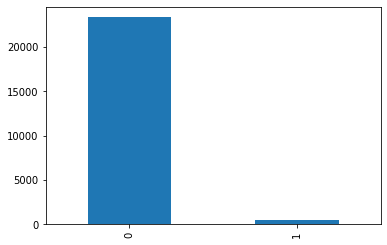

In [11]:
# now for the important part, lets plot the distribution of the cancer among the breasts
train_df.groupby("breast_id")["cancer"].max().value_counts().plot(kind="bar")

Wow, we are looking at a severely imbalanced dataset.


In [12]:
# lets look at the stats
print ("Total Number of breasts:", len(train_df.groupby("breast_id")))

distribution = train_df.groupby("breast_id")["cancer"].max().value_counts()
print("no cancer: ", distribution[0])
print("cancer   : ", distribution[1])

zeros = np.zeros(distribution[0])
ones = np.ones(distribution[1])
y = np.concatenate([zeros, ones])

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
print("class weights: ", class_weights)

Total Number of breasts: 23826
no cancer:  23334
cancer   :  492
class weights:  [ 0.51054256 24.21341463]


In [13]:
# as you can see some cases has 3 different views
# lets see the cases with 3 views
grouped = train_df.groupby("breast_id")

for breast_id, group in grouped:
    if group["view"].nunique() == 3:
        display(group)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
2009,1,12161,1465495964,R,MLO,55.0,0,0,0,0.0,0,C,170,True,12161_R
2010,1,12161,1671936115,R,ML,55.0,0,0,0,0.0,0,C,170,True,12161_R
2011,1,12161,1800679483,R,CC,55.0,0,0,0,0.0,0,C,170,True,12161_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
4731,1,1511,503850980,L,MLO,63.0,0,0,0,0.0,0,C,49,True,1511_L
4732,1,1511,764545189,L,MLO,63.0,0,0,0,0.0,0,C,49,True,1511_L
4733,1,1511,790068662,L,CC,63.0,0,0,0,0.0,0,C,49,True,1511_L
4734,1,1511,1031853445,L,CC,63.0,0,0,0,0.0,0,C,49,True,1511_L
4735,1,1511,1273092690,L,CC,63.0,0,0,0,0.0,0,C,49,True,1511_L
4736,1,1511,1760744211,L,ML,63.0,0,0,0,0.0,0,C,49,True,1511_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
4784,2,15154,130307999,R,CC,67.0,0,0,0,NaN,0,NaN,48,False,15154_R
4785,2,15154,979422762,R,LM,67.0,0,0,0,NaN,0,NaN,48,False,15154_R
4786,2,15154,1277847107,R,MLO,67.0,0,0,0,NaN,0,NaN,48,False,15154_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
8478,1,19066,77539981,L,MLO,83.0,0,0,0,2.0,0,B,49,False,19066_L
8479,1,19066,1754894704,L,LM,83.0,0,0,0,2.0,0,B,49,False,19066_L
8480,1,19066,1926937099,L,CC,83.0,0,0,0,2.0,0,B,49,False,19066_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
8481,1,19066,471391133,R,CC,83.0,0,0,0,NaN,0,B,49,False,19066_R
8482,1,19066,1548651850,R,MLO,83.0,0,0,0,NaN,0,B,49,False,19066_R
8483,1,19066,1872785516,R,LM,83.0,0,0,0,NaN,0,B,49,False,19066_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
9606,1,2028,1616039919,R,MLO,81.0,0,0,0,NaN,0,A,49,False,2028_R
9607,1,2028,1815868287,R,CC,81.0,0,0,0,NaN,0,A,49,False,2028_R
9608,1,2028,1955295882,R,CC,81.0,0,0,0,NaN,0,A,49,False,2028_R
9609,1,2028,2082854771,R,AT,81.0,0,0,0,NaN,0,A,49,False,2028_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
11936,1,22766,200520414,R,MLO,47.0,0,0,0,NaN,0,C,49,False,22766_R
11937,1,22766,478904995,R,CC,47.0,0,0,0,NaN,0,C,49,False,22766_R
11938,1,22766,1144373872,R,CC,47.0,0,0,0,NaN,0,C,49,False,22766_R
11939,1,22766,1285868936,R,CC,47.0,0,0,0,NaN,0,C,49,False,22766_R
11940,1,22766,1696722394,R,MLO,47.0,0,0,0,NaN,0,C,49,False,22766_R
11941,1,22766,2130401243,R,LM,47.0,0,0,0,NaN,0,C,49,False,22766_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
14339,1,25323,106495931,R,AT,74.0,1,1,1,0.0,0,B,49,False,25323_R
14340,1,25323,361875956,R,MLO,74.0,1,1,1,0.0,0,B,49,False,25323_R
14341,1,25323,396189007,R,MLO,74.0,1,1,1,0.0,0,B,49,False,25323_R
14342,1,25323,1245090607,R,CC,74.0,1,1,1,0.0,0,B,49,False,25323_R
14343,1,25323,1743461841,R,AT,74.0,1,1,1,0.0,0,B,49,False,25323_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
15529,1,26530,166085523,L,AT,41.0,0,0,0,1.0,0,A,49,False,26530_L
15530,1,26530,346592584,L,MLO,41.0,0,0,0,1.0,0,A,49,False,26530_L
15531,1,26530,815322288,L,MLO,41.0,0,0,0,1.0,0,A,49,False,26530_L
15532,1,26530,913554226,L,CC,41.0,0,0,0,1.0,0,A,49,False,26530_L
15533,1,26530,1652786431,L,CC,41.0,0,0,0,1.0,0,A,49,False,26530_L
15534,1,26530,1772580395,L,CC,41.0,0,0,0,1.0,0,A,49,False,26530_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
15535,1,26530,222835190,R,CC,41.0,0,0,0,1.0,0,A,49,False,26530_R
15536,1,26530,305723519,R,MLO,41.0,0,0,0,1.0,0,A,49,False,26530_R
15537,1,26530,346547614,R,MLO,41.0,0,0,0,1.0,0,A,49,False,26530_R
15538,1,26530,877218507,R,AT,41.0,0,0,0,1.0,0,A,49,False,26530_R
15539,1,26530,918109906,R,CC,41.0,0,0,0,1.0,0,A,49,False,26530_R
15540,1,26530,1262426307,R,CC,41.0,0,0,0,1.0,0,A,49,False,26530_R
15541,1,26530,2121614268,R,MLO,41.0,0,0,0,1.0,0,A,49,False,26530_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
18854,1,29907,342138650,R,AT,53.0,0,0,0,NaN,0,B,49,False,29907_R
18855,1,29907,842209441,R,MLO,53.0,0,0,0,NaN,0,B,49,False,29907_R
18856,1,29907,948174864,R,CC,53.0,0,0,0,NaN,0,B,49,False,29907_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
18984,1,30052,752465933,L,CC,40.0,0,0,0,NaN,0,C,49,False,30052_L
18985,1,30052,1086113697,L,AT,40.0,0,0,0,NaN,0,C,49,False,30052_L
18986,1,30052,1683139460,L,MLO,40.0,0,0,0,NaN,0,C,49,False,30052_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
20253,1,31477,1239389288,R,MLO,49.0,0,0,0,1.0,0,C,49,False,31477_R
20254,1,31477,1604164780,R,LMO,49.0,0,0,0,1.0,0,C,49,False,31477_R
20255,1,31477,1881597105,R,CC,49.0,0,0,0,1.0,0,C,49,False,31477_R
20256,1,31477,2056832119,R,MLO,49.0,0,0,0,1.0,0,C,49,False,31477_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
22411,1,3386,917413880,L,AT,42.0,0,0,0,NaN,0,D,49,False,3386_L
22412,1,3386,1581687486,L,CC,42.0,0,0,0,NaN,0,D,49,False,3386_L
22413,1,3386,1984020825,L,MLO,42.0,0,0,0,NaN,0,D,49,False,3386_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
22414,1,3386,318145499,R,MLO,42.0,0,1,0,0.0,0,D,49,True,3386_R
22415,1,3386,602126376,R,AT,42.0,0,1,0,0.0,0,D,49,True,3386_R
22416,1,3386,1258195376,R,CC,42.0,0,1,0,0.0,0,D,49,True,3386_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
22874,1,34349,9679195,L,CC,67.0,0,0,0,1.0,0,B,93,False,34349_L
22875,1,34349,322620901,L,ML,67.0,0,0,0,1.0,0,B,93,False,34349_L
22876,1,34349,1422925035,L,MLO,67.0,0,0,0,1.0,0,B,93,False,34349_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
22877,1,34349,457295443,R,CC,67.0,0,0,0,1.0,0,B,93,False,34349_R
22878,1,34349,546517982,R,MLO,67.0,0,0,0,1.0,0,B,93,False,34349_R
22879,1,34349,1433982072,R,ML,67.0,0,0,0,1.0,0,B,93,False,34349_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
25119,1,36858,522716037,L,CC,55.0,0,0,0,1.0,0,C,49,False,36858_L
25120,1,36858,1776757952,L,AT,55.0,0,0,0,1.0,0,C,49,False,36858_L
25121,1,36858,1993652260,L,MLO,55.0,0,0,0,1.0,0,C,49,False,36858_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
25122,1,36858,754923,R,MLO,55.0,0,0,0,1.0,0,C,49,False,36858_R
25123,1,36858,267753704,R,AT,55.0,0,0,0,1.0,0,C,49,False,36858_R
25124,1,36858,1447012518,R,CC,55.0,0,0,0,1.0,0,C,49,False,36858_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
26887,1,38739,1110010839,R,AT,62.0,0,0,0,2.0,0,C,49,False,38739_R
26888,1,38739,1189630231,R,CC,62.0,0,0,0,2.0,0,C,49,False,38739_R
26889,1,38739,1632645203,R,CC,62.0,0,0,0,2.0,0,C,49,False,38739_R
26890,1,38739,1856537005,R,MLO,62.0,0,0,0,2.0,0,C,49,False,38739_R
26891,1,38739,1889694445,R,MLO,62.0,0,0,0,2.0,0,C,49,False,38739_R
26892,1,38739,2070012385,R,CC,62.0,0,0,0,2.0,0,C,49,False,38739_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
28329,2,40235,771225790,L,LM,65.0,0,0,0,NaN,0,NaN,48,False,40235_L
28330,2,40235,1384690276,L,MLO,65.0,0,0,0,NaN,0,NaN,48,False,40235_L
28331,2,40235,2109086136,L,CC,65.0,0,0,0,NaN,0,NaN,48,False,40235_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
28332,2,40235,232492757,R,MLO,65.0,0,0,0,NaN,0,NaN,48,False,40235_R
28333,2,40235,764348835,R,CC,65.0,0,0,0,NaN,0,NaN,48,False,40235_R
28334,2,40235,1473114297,R,LM,65.0,0,0,0,NaN,0,NaN,48,False,40235_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
28415,1,40317,174010701,R,MLO,58.0,0,1,0,0.0,0,C,49,True,40317_R
28416,1,40317,840036202,R,ML,58.0,0,1,0,0.0,0,C,49,True,40317_R
28417,1,40317,1168530753,R,CC,58.0,0,1,0,0.0,0,C,49,True,40317_R
28418,1,40317,1731860990,R,CC,58.0,0,1,0,0.0,0,C,49,True,40317_R
28419,1,40317,1846823045,R,ML,58.0,0,1,0,0.0,0,C,49,True,40317_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
28872,2,40832,38671060,L,MLO,64.0,0,0,0,0.0,0,NaN,21,True,40832_L
28873,2,40832,401408533,L,CC,64.0,0,0,0,0.0,0,NaN,21,True,40832_L
28874,2,40832,1754463254,L,LM,64.0,0,0,0,0.0,0,NaN,21,True,40832_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
28875,2,40832,129895743,R,CC,64.0,0,0,0,NaN,0,NaN,21,False,40832_R
28876,2,40832,1860053373,R,MLO,64.0,0,0,0,NaN,0,NaN,21,False,40832_R
28877,2,40832,1964144553,R,LM,64.0,0,0,0,NaN,0,NaN,21,False,40832_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
29663,1,41618,382093195,L,AT,89.0,0,0,0,0.0,0,C,49,True,41618_L
29664,1,41618,433225582,L,MLO,89.0,0,0,0,0.0,0,C,49,True,41618_L
29665,1,41618,1162110691,L,CC,89.0,0,0,0,0.0,0,C,49,True,41618_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
29698,1,41647,502713799,L,MLO,71.0,0,0,0,1.0,0,A,49,False,41647_L
29699,1,41647,979922578,L,CC,71.0,0,0,0,1.0,0,A,49,False,41647_L
29700,1,41647,1821746684,L,MLO,71.0,0,0,0,1.0,0,A,49,False,41647_L
29701,1,41647,1884352655,L,CC,71.0,0,0,0,1.0,0,A,49,False,41647_L
29702,1,41647,2115055383,L,AT,71.0,0,0,0,1.0,0,A,49,False,41647_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
29703,1,41647,757024574,R,CC,71.0,0,0,0,1.0,0,A,49,False,41647_R
29704,1,41647,1330615132,R,AT,71.0,0,0,0,1.0,0,A,49,False,41647_R
29705,1,41647,1373434747,R,MLO,71.0,0,0,0,1.0,0,A,49,False,41647_R
29706,1,41647,1439536065,R,MLO,71.0,0,0,0,1.0,0,A,49,False,41647_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
31143,1,43377,509624452,R,MLO,66.0,0,0,0,2.0,0,B,49,False,43377_R
31144,1,43377,673653549,R,AT,66.0,0,0,0,2.0,0,B,49,False,43377_R
31145,1,43377,1005546500,R,CC,66.0,0,0,0,2.0,0,B,49,False,43377_R
31146,1,43377,1827841858,R,CC,66.0,0,0,0,2.0,0,B,49,False,43377_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
33083,1,45423,542547350,R,ML,73.0,0,1,0,0.0,0,C,49,True,45423_R
33084,1,45423,588362291,R,MLO,73.0,0,1,0,0.0,0,C,49,True,45423_R
33085,1,45423,1283318410,R,MLO,73.0,0,1,0,0.0,0,C,49,True,45423_R
33086,1,45423,1591300005,R,CC,73.0,0,1,0,0.0,0,C,49,True,45423_R
33087,1,45423,1711858065,R,CC,73.0,0,1,0,0.0,0,C,49,True,45423_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
37673,1,50454,808829140,L,CC,86.0,0,0,0,1.0,0,A,93,False,50454_L
37674,1,50454,1024751982,L,MLO,86.0,0,0,0,1.0,0,A,93,False,50454_L
37675,1,50454,1133144412,L,LM,86.0,0,0,0,1.0,0,A,93,False,50454_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
38068,1,50865,194452157,R,CC,69.0,0,0,0,2.0,0,C,49,False,50865_R
38069,1,50865,887011196,R,LM,69.0,0,0,0,2.0,0,C,49,False,50865_R
38070,1,50865,1300811675,R,CC,69.0,0,0,0,2.0,0,C,49,False,50865_R
38071,1,50865,1928710268,R,MLO,69.0,0,0,0,2.0,0,C,49,False,50865_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
42765,1,56100,1190628,R,MLO,57.0,0,0,0,NaN,0,B,49,False,56100_R
42766,1,56100,144004687,R,CC,57.0,0,0,0,NaN,0,B,49,False,56100_R
42767,1,56100,1648618026,R,AT,57.0,0,0,0,NaN,0,B,49,False,56100_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
45132,1,58628,1293543661,L,ML,53.0,0,0,0,1.0,0,B,49,False,58628_L
45133,1,58628,1454611157,L,CC,53.0,0,0,0,1.0,0,B,49,False,58628_L
45134,1,58628,2034448419,L,MLO,53.0,0,0,0,1.0,0,B,49,False,58628_L


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
50647,1,64595,332693390,R,MLO,56.0,0,0,0,1.0,0,B,170,False,64595_R
50648,1,64595,1205638491,R,CC,56.0,0,0,0,1.0,0,B,170,False,64595_R
50649,1,64595,2049381705,R,AT,56.0,0,0,0,1.0,0,B,170,False,64595_R


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id
52400,1,7412,264916633,L,AT,78.0,0,0,0,NaN,0,B,49,False,7412_L
52401,1,7412,1378096953,L,CC,78.0,0,0,0,NaN,0,B,49,False,7412_L
52402,1,7412,1594796661,L,MLO,78.0,0,0,0,NaN,0,B,49,False,7412_L


Even in above anomalies, there is always a MLO and a CC view.
So i suppose one can discard the rest of views.

In [14]:
# we found out that a breast can have MLO, ML, CC, AT, LM views.
# We know that every breast has at least two views.
# But we didnt check if they are spesifically CC and MLO views.
# lets check that

for breast_id, group in train_df.groupby("breast_id"):
    if not ("CC" in group["view"].values and "MLO" in group["view"].values):
        display(group)

There was no output. That means that every breast has at least one CC view and one MLO view.

In [15]:
# now for the hard part (inspecting image dimensions)
# lets add the dicom image dimensions to the dataframe 
# WARNING: this cell takes about 50 minute to execute

def get_image_dimensions(image_path) -> tuple:
    image_path = os.path.join("../input/rsna-breast-cancer-detection/train_images", image_path)
    image = pydicom.dcmread(image_path)
    return image.Rows, image.Columns

train_df["image_path"] = train_df["patient_id"].astype(str) + "/" + train_df["image_id"].astype(str) + ".dcm"
train_df["image_dimension_x"], train_df["image_dimension_y"] = zip(*train_df["image_path"].apply(get_image_dimensions))


Well, this takes way too much time. I dont even know if above cell is working.

300 gigabytes is way too much data to read, let alone preprocess and train, and make inference. I suppose one can upload their preprocessed training dataset to kaggle and use it for training.

In [16]:
# lets see random 20 rows
train_df.sample(20)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,breast_id,image_path,image_dimension_x,image_dimension_y
13881,1,24837,445113117,L,MLO,72.0,0,0,0,1.0,0,B,49,False,24837_L,24837/445113117.dcm,3328,2560
18411,1,29439,762909887,L,CC,67.0,0,0,0,0.0,0,B,49,True,29439_L,29439/762909887.dcm,4096,3328
54441,1,9646,802166647,R,MLO,80.0,0,0,0,1.0,0,A,49,False,9646_R,9646/802166647.dcm,4096,3328
25003,1,36748,240108548,L,CC,55.0,1,1,0,0.0,0,C,49,False,36748_L,36748/240108548.dcm,3328,2560
7810,1,18325,439281249,R,MLO,57.0,0,0,0,NaN,0,C,49,False,18325_R,18325/439281249.dcm,3328,2560
15233,1,26223,1763174994,R,CC,64.0,0,0,0,0.0,0,B,93,True,26223_R,26223/1763174994.dcm,2294,1914
43728,2,57126,893050404,R,MLO,62.0,0,0,0,NaN,0,NaN,29,False,57126_R,57126/893050404.dcm,5355,4915
45858,2,59356,1328561392,R,MLO,62.0,0,0,0,0.0,0,NaN,29,True,59356_R,59356/1328561392.dcm,5355,4915
39484,1,52612,1679770007,R,MLO,66.0,0,0,0,0.0,0,C,49,True,52612_R,52612/1679770007.dcm,4096,3328
14314,2,25304,1184375863,L,CC,52.0,0,0,0,NaN,0,NaN,21,False,25304_L,25304/1184375863.dcm,2776,2082


In [17]:
# mean image dimensions
train_df["image_dimension_x"].mean(), train_df["image_dimension_y"].mean()

(3867.246737103791, 3173.1003911819544)

In [18]:
# variance of image dimensions
train_df["image_dimension_x"].var(), train_df["image_dimension_y"].var()

(759026.3279324116, 819753.3992258774)

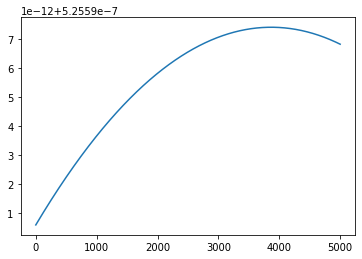

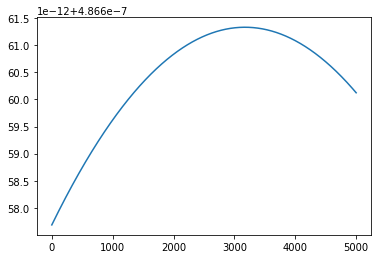

In [19]:
# lets draw normal distribution of image dimensions using mean and variance
import scipy.stats as stats

x = np.linspace(0, 5000, 5000)
plt.plot(x, stats.norm.pdf(x, train_df["image_dimension_x"].mean(), train_df["image_dimension_x"].var()))
plt.show()

x = np.linspace(0, 5000, 5000)
plt.plot(x, stats.norm.pdf(x, train_df["image_dimension_y"].mean(), train_df["image_dimension_y"].var()))
plt.show()

In [20]:
# min and max image dimensions
print(f"x min: \t {train_df['image_dimension_x'].min()} \t x max: \t {train_df['image_dimension_x'].max()}")
print(f"y min: \t {train_df['image_dimension_y'].min()} \t y max: \t {train_df['image_dimension_y'].max()}")

x min: 	 1236 	 x max: 	 5928
y min: 	 1022 	 y max: 	 4915


<AxesSubplot:>

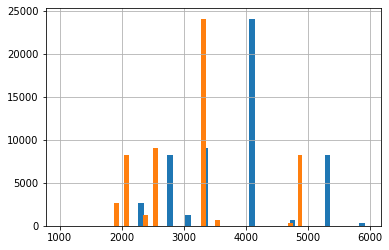

In [21]:
# lets plot the distribution of the image dimensions
train_df["image_dimension_x"].hist(bins=50)
train_df["image_dimension_y"].hist(bins=50)


In [22]:
train_df.to_csv("train_df_processed.csv", index=False)